## Задание 

Выберите ряд из первого задания и постройте его модель ARIMA/GARCH.  
Дополнительное задание: попробуйте спрогнозировать график классическим ML.  

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


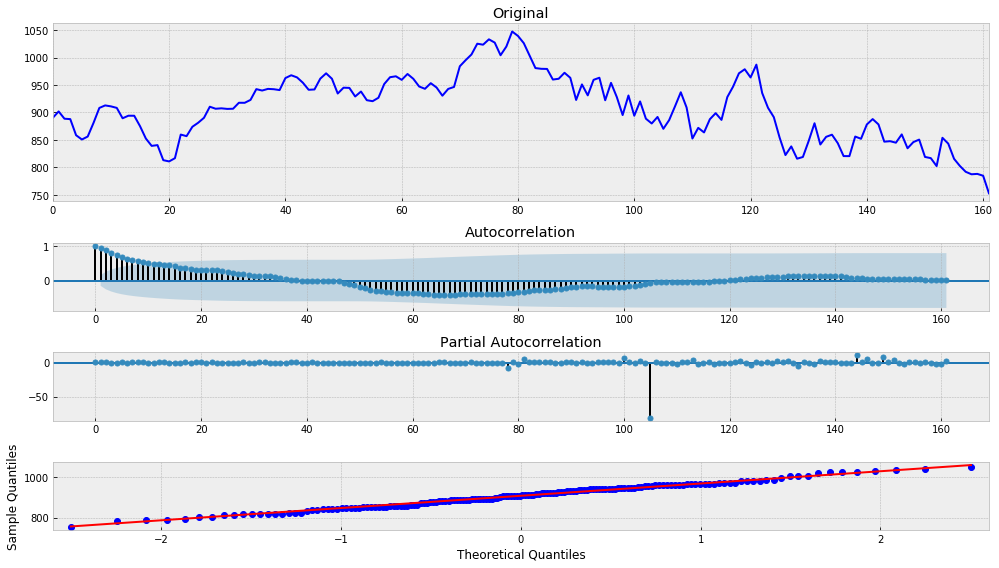

In [5]:
dowjones_closing = pd.read_csv("../data/weekly-closings-of-the-dowjones-.csv")
series = dowjones_closing.Close
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


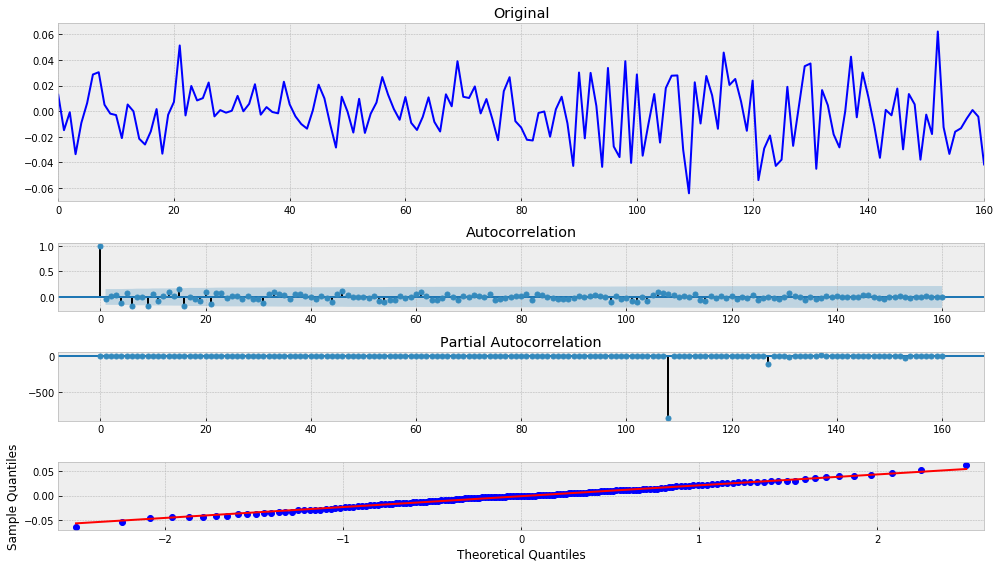

In [6]:
# сделаем временной ряд стационарным
series = boxcox(series, 0)
series = np.diff(series, 1)
tsplot(series)

In [7]:
aic, order, mdl = _get_best_model(series)

aic: -766.36722 | order: (1, 0, 0)


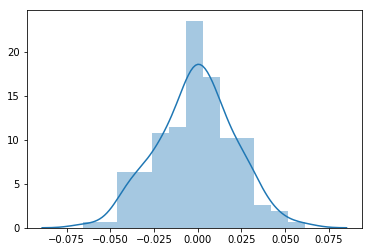

In [8]:
# распределение остатков близко к нормальному 
sns.distplot(mdl.resid)

In [9]:
# Используем параметры, полученные от ARIMA, в модели GARCH
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     44,   Neg. LLF: -384.1194911179083
Iteration:     10,   Func. Count:     77,   Neg. LLF: -385.37566594880303
Iteration:     15,   Func. Count:    107,   Neg. LLF: -385.7365262556166
Iteration:     20,   Func. Count:    137,   Neg. LLF: -385.8180123717309
Iteration:     25,   Func. Count:    168,   Neg. LLF: -385.8247743950745
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -385.82574855353283
            Iterations: 28
            Function evaluations: 198
            Gradient evaluations: 28
                         Constant Mean - ARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             ARCH   Log-Likelihood:                385.826
Distribution:      Standardized Student's t   AIC:                          -763.

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


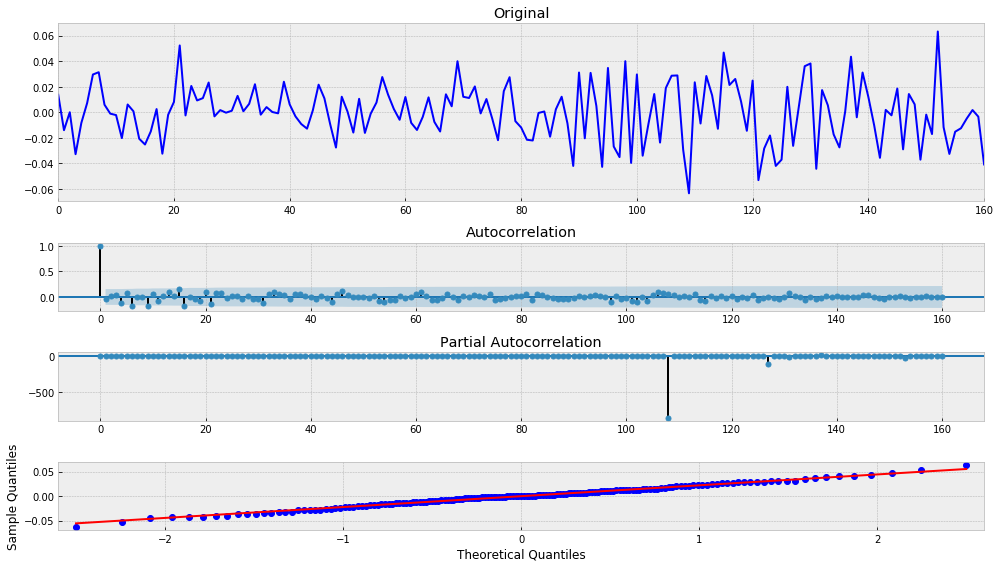

In [10]:
tsplot(res.resid)

### Прогнозируем временной ряд с использованием моделей классического ML

In [11]:
def prepareData(data, field_name, lag_start=5, lag_end=20, test_size=0.15):
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[field_name].shift(i)
        
    data = data.dropna()
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([field_name], axis=1)
    y_train = data.loc[:test_index][field_name]
    X_test = data.loc[test_index:].drop([field_name], axis=1)
    y_test = data.loc[test_index:][field_name]
    
    return X_train, X_test, y_train, y_test

In [12]:
dowjones_closing = pd.read_csv("../data/weekly-closings-of-the-dowjones-.csv")
series = dowjones_closing.Close

X_train, X_test, y_train, y_test = prepareData(series, field_name='Close', lag_start=1, lag_end=20, test_size=0.2)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [14]:
models = [LinearRegression(), RandomForestRegressor(1000), 
          CatBoostRegressor(1000, verbose=False), KNeighborsRegressor(3)]
predictions = []

for model in models:
    model.fit(X_train, y_train)
    predictions.append(model.predict(X_test))

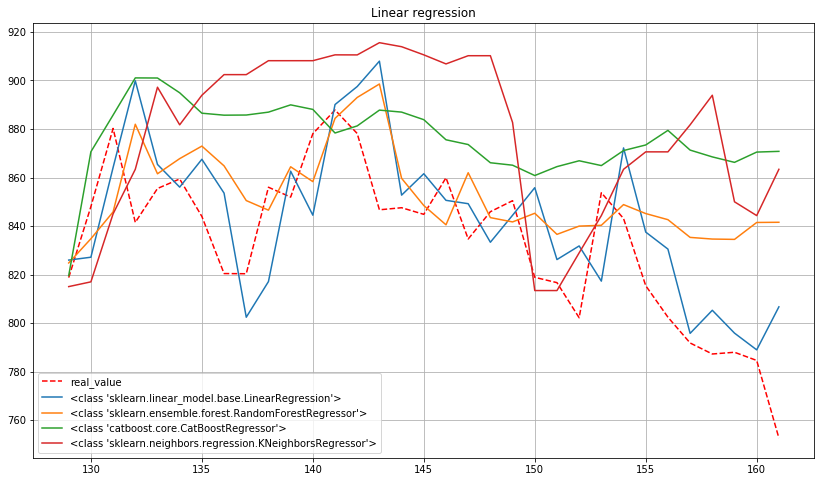

In [15]:
plt.figure(figsize=(14, 8))

plt.plot(y_test, "r--", label="real_value")
for id_, y_pred in enumerate(predictions):
    y_pred = pd.Series(y_pred, index=y_test.index)
    plt.plot(y_pred, label=str(models[id_].__class__))

plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [16]:
for id_, y_pred in enumerate(predictions):
    y_pred = pd.Series(y_pred, index=y_test.index)
    print(f'RMSE for {models[id_].__class__} : {np.sqrt(mean_squared_error(y_pred, y_test))}')

RMSE for <class 'sklearn.linear_model.base.LinearRegression'> : 26.442001446967797
RMSE for <class 'sklearn.ensemble.forest.RandomForestRegressor'> : 32.32695410264007
RMSE for <class 'catboost.core.CatBoostRegressor'> : 51.17065866747333
RMSE for <class 'sklearn.neighbors.regression.KNeighborsRegressor'> : 56.12448482287384
